## Topography filtering and vertical integral (barotropic component)

We don't really want to filter topography, as a coarse model is sort of a sub-sampled topography rather than filtered. 

Here we see if this impacts the thickness fluxes. 

Also in parameterizations often the vertical integral of thickness fluxes is set to zero. Here we check well this assumption holds with data. 

#### Setup dask

When doing filtering, it may be useful to use many processes as it is very slow but easily parallelizable. 

In [1]:
I_want_dask = False

if I_want_dask: 
    from dask_gateway import Gateway
    gateway = Gateway()
    
    # close existing clusters
    open_clusters = gateway.list_clusters()
    print(list(open_clusters))
    
    flag_shut = False 
    
    if flag_shut: 
        if len(open_clusters)>0:
            for c in open_clusters:
                cluster = gateway.connect(c.name)
                cluster.shutdown()  
    
    options = gateway.cluster_options()
    
    #options.worker_memory = 16 # 24 works fine for long term mean, but seasonal needs a bit more
    # options.worker_cores = 8
    
    options.environment = dict(
        DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0"
    )
    
    # Create a cluster with those options
    cluster = gateway.new_cluster(options)
    client = cluster.get_client()
    cluster.adapt(15, 40)
    #cluster.scale(10)
    client

### Start

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xgcm import Grid
#from xmitgcm import open_mdsdataset
import xrft
#from scipy.ndimage import gaussian_filter
import gcm_filters as gcmf

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']

In [4]:
ds = xr.open_zarr(f'{PERSISTENT_BUCKET}/MOM6/Double_Gyre/res5km/prog.zarr').isel(Time=-1)

In [5]:
ds

<xarray.Dataset> Size: 9MB
Dimensions:  (zl: 2, yq: 441, xq: 401, zi: 3, yh: 440, xh: 400)
Coordinates:
    Time     object 8B 0099-07-26 00:00:00
  * xh       (xh) float64 3kB 0.0275 0.0825 0.1375 0.1925 ... 21.86 21.92 21.97
  * xq       (xq) float64 3kB 0.0 0.055 0.11 0.165 ... 21.84 21.89 21.95 22.0
  * yh       (yh) float64 4kB 30.02 30.07 30.11 30.16 ... 49.89 49.93 49.98
  * yq       (yq) float64 4kB 30.0 30.05 30.09 30.14 ... 49.86 49.91 49.95 50.0
  * zi       (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
  * zl       (zl) float64 16B 1.035e+03 1.036e+03
Data variables:
    RV       (zl, yq, xq) float32 1MB dask.array<chunksize=(2, 441, 401), meta=np.ndarray>
    e        (zi, yh, xh) float32 2MB dask.array<chunksize=(3, 440, 400), meta=np.ndarray>
    h        (zl, yh, xh) float64 3MB dask.array<chunksize=(2, 440, 400), meta=np.ndarray>
    u        (zl, yh, xq) float32 1MB dask.array<chunksize=(2, 440, 401), meta=np.ndarray>
    v        (zl, yq, xh) float32 1MB dask.array<chunksize=(2, 441, 400), meta=np.ndarray>
Attributes:
    filename:   prog__000010.nc
    grid_tile:  N/A
    grid_type:  regular
    title:      MOM Experiment

In [6]:
## Create grid area element
coords = {'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'},
            'Z': {'center': 'zl', 'outer': 'zi'} }

grid = Grid(ds, coords=coords)

In [7]:
dx = 110e3* grid.diff(ds.xq,'X', boundary='extend') * np.cos(ds.yh*np.pi/180)
dy = 110e3* grid.diff(ds.yq,'Y', boundary='extend')
area_t = dy*dx

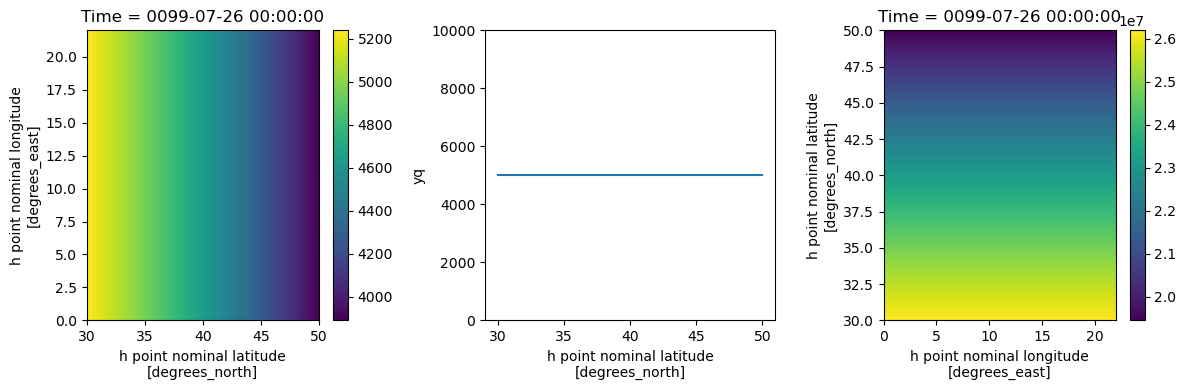

In [8]:
plt.figure(figsize=(12,4))
           
plt.subplot(131)
dx.plot()

plt.subplot(132)
dy.plot()
plt.ylim(0, 10e3)

plt.subplot(133) 
area_t.plot()

plt.tight_layout()

### Model state

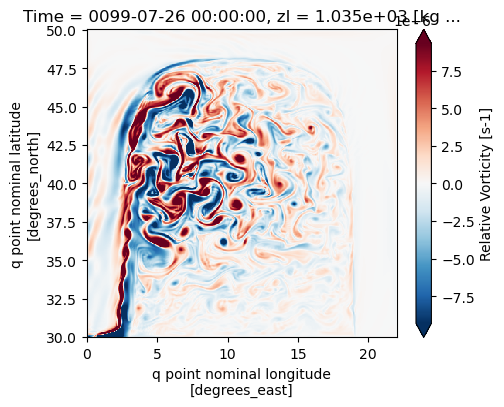

In [9]:
plt.figure(figsize=(5,4))
ds.RV.isel( zl=0).plot(robust=True)

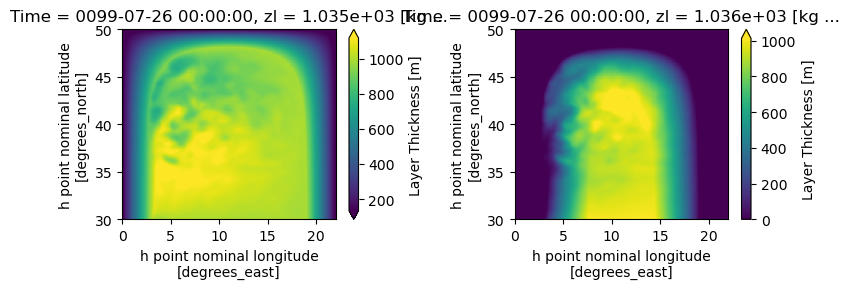

In [10]:
plt.figure(figsize=(8,3))

plt.subplot(121)
ds.h.isel( zl=0).plot(robust=True)

plt.subplot(122)
ds.h.isel( zl=1).plot(robust=True)

plt.tight_layout()

Text(0.5, 1.0, 'Thicknesses')

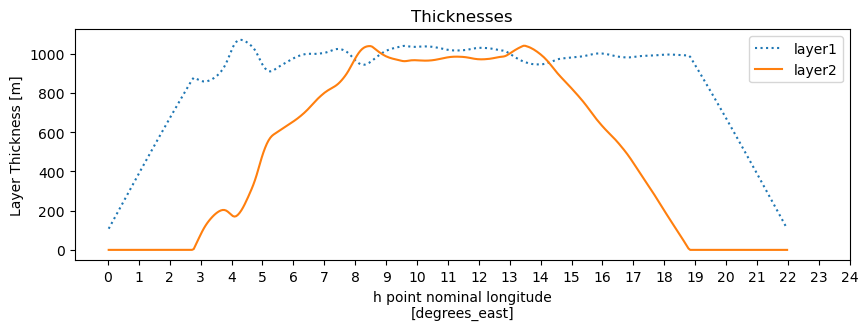

In [11]:
plt.figure(figsize=(10,3))
ds.h.isel( zl=0).sel(yh=40, method='nearest').plot(linestyle=':',label='layer1')
ds.h.isel( zl=1).sel(yh=40, method='nearest').plot(label='layer2')
plt.legend()
plt.xticks(np.arange(0,25, 1));
plt.title('Thicknesses')

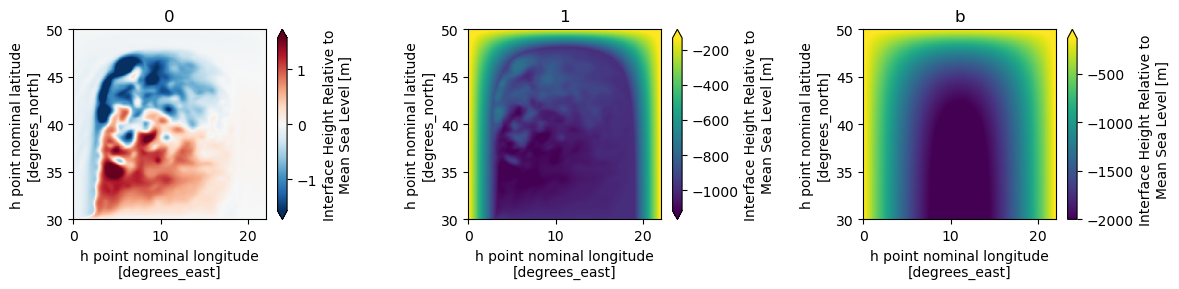

In [12]:
plt.figure(figsize=(12,3))

plt.subplot(131)
ds.e.isel( zi=0).plot(robust=True)
plt.title('0')

plt.subplot(132)
ds.e.isel( zi=1).plot(robust=True)
plt.title('1')

plt.subplot(133)
ds.e.isel( zi=2).plot(robust=True)
plt.title('b')

plt.tight_layout()

Text(0.5, 1.0, 'interfaces')

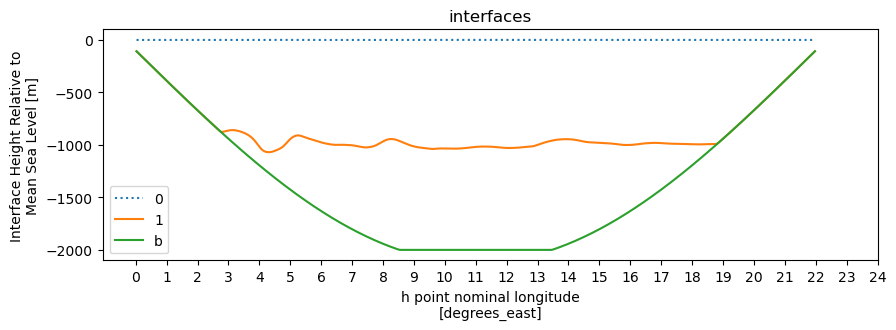

In [13]:
plt.figure(figsize=(10,3))
ds.e.isel( zi=0).sel(yh=40, method='nearest').plot(linestyle=':',label='0')
ds.e.isel( zi=1).sel(yh=40, method='nearest').plot(label='1')
ds.e.isel( zi=2).sel(yh=40, method='nearest').plot(label='b')
plt.legend()
plt.xticks(np.arange(0,25, 1));
plt.title('interfaces')

Text(0.5, 1.0, 'interfaces')

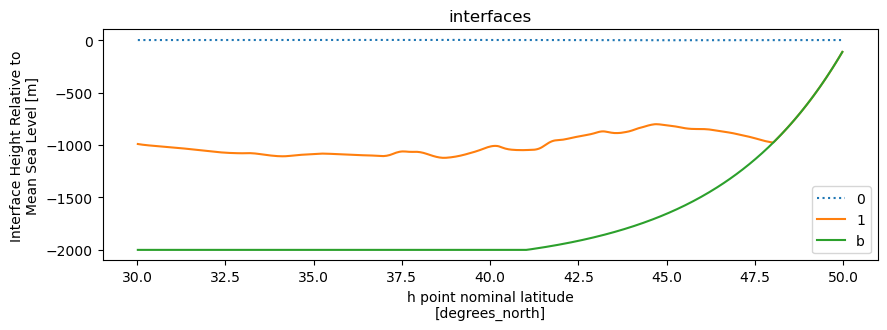

In [14]:
plt.figure(figsize=(10,3))
ds.e.isel( zi=0).sel(xh=9, method='nearest').plot(linestyle=':',label='0')
ds.e.isel( zi=1).sel(xh=9, method='nearest').plot(label='1')
ds.e.isel( zi=2).sel(xh=9, method='nearest').plot(label='b')
plt.legend()
#plt.xticks(np.arange(0,25, 1));
plt.title('interfaces')

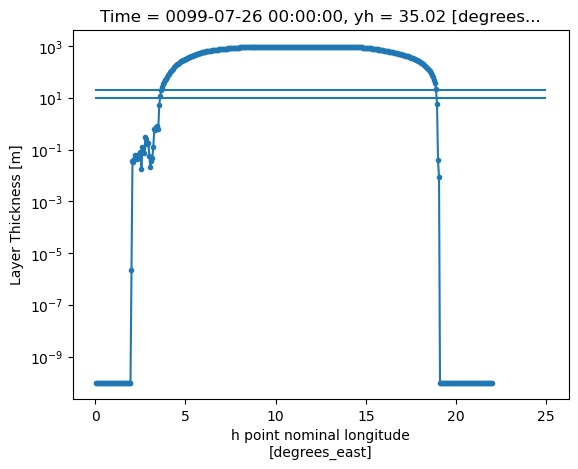

In [15]:
ds.h.isel( zl=1).sel(yh=35, method='nearest').plot(marker='.')
plt.hlines([10,20], 0, 25)
plt.yscale('log')

### Filtering

In [16]:
#ds = ds.isel(Time=slice(-3,-1))

In [15]:
#Lfilter = 100e3
#dx = 1/20 * 100e3
filter_scale = 20 
dx_min = 1

In [16]:
## Choose wet mask based on how deep the layer is

#wet_mask= (ds.h.isel(Time=0, zl=0)*0. + 1.).rename('wet_mask')
#wet_mask= (ds.h.isel(Time=0, zl=1)>1).astype('float32').rename('wet_mask')
#wet_mask= (ds.h.isel(zl=1)>1).astype('float32').rename('wet_mask')
wet_mask_h= (ds.h>20).astype('float32').rename('wet_mask')
# Changning this wet mask changes things a little bit. 

In [17]:
## Set edges to 0 
wet_mask_h = wet_mask_h.where(ds.yh>=30.03, other=0)
wet_mask_h = wet_mask_h.where(ds.xh>=0.03, other=0)

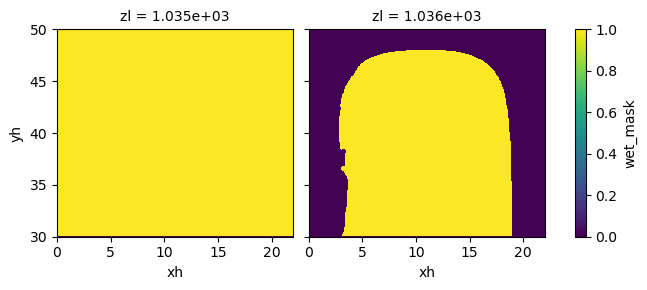

In [18]:
wet_mask_h.plot(col='zl')

In [19]:
# Make wet mask for interface points, by taking the mask for the layer below.
wet_mask_e = wet_mask_h.copy()
wet_mask_e = wet_mask_e.rename({'zl': 'zi'}).drop_vars('zi')
#zeros_array = xr.DataArray(np.zeros((wet_mask_e.sizes['Time'], 1, wet_mask_e.sizes['yh'], wet_mask_e.sizes['xh'])),
#                           dims=('Time', 'zi', 'yh', 'xh'))
zeros_array = xr.DataArray(np.zeros(( 1, wet_mask_e.sizes['yh'], wet_mask_e.sizes['xh'])),
                           dims=('zi', 'yh', 'xh'))
wet_mask_e = xr.concat([wet_mask_e, zeros_array], dim='zi').chunk({'zi':-1, 'xh':-1,'yh':-1})

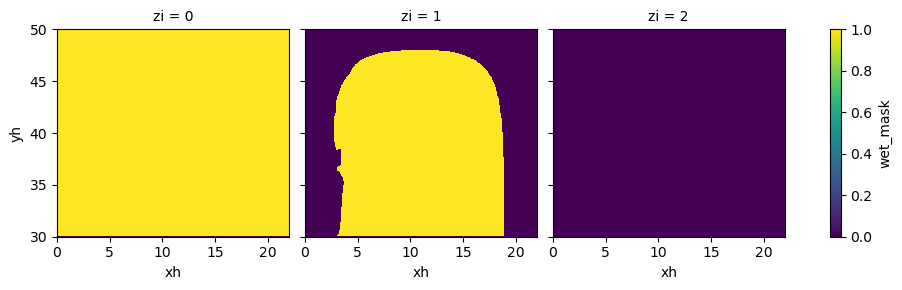

In [20]:
wet_mask_e.plot(col='zi')

In [21]:
filter_C_h = gcmf.Filter(filter_scale= filter_scale,  
                     dx_min = dx_min, 
                     filter_shape=gcmf.FilterShape.GAUSSIAN,
                     grid_type=gcmf.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
                     grid_vars = {'area':area_t,'wet_mask': wet_mask_h})

In [22]:
filter_C_e = gcmf.Filter(filter_scale= filter_scale,  
                     dx_min = dx_min, 
                     filter_shape=gcmf.FilterShape.GAUSSIAN,
                     grid_type=gcmf.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
                     grid_vars = {'area':area_t,'wet_mask': wet_mask_e})

In [23]:
xgrid = Grid(ds, coords={'X': {'center': 'xh', 'outer': 'xq'},
                         'Y': {'center': 'yh', 'outer': 'yq'},
                         'Z': {'center': 'zl', 'outer': 'zi'} },
             periodic=['X'])

In [24]:
ds_filt = xr.Dataset() 
ds_filt['h'] = filter_C_h.apply(ds.h, dims=['yh','xh']).rename('h')
ds_filt['e'] = filter_C_e.apply(ds.e, dims=['yh','xh']).rename('e')

In [25]:
ds_filt=ds_filt

In [26]:
ds_anom = ds - ds_filt

In [27]:
ds_anom

<xarray.Dataset> Size: 5MB
Dimensions:  (xh: 400, xq: 401, yh: 440, yq: 441, zi: 3, zl: 2)
Coordinates:
    Time     object 8B 0099-07-26 00:00:00
  * xh       (xh) float64 3kB 0.0275 0.0825 0.1375 0.1925 ... 21.86 21.92 21.97
  * xq       (xq) float64 3kB 0.0 0.055 0.11 0.165 ... 21.84 21.89 21.95 22.0
  * yh       (yh) float64 4kB 30.02 30.07 30.11 30.16 ... 49.89 49.93 49.98
  * yq       (yq) float64 4kB 30.0 30.05 30.09 30.14 ... 49.86 49.91 49.95 50.0
  * zi       (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
  * zl       (zl) float64 16B 1.035e+03 1.036e+03
Data variables:
    e        (zi, yh, xh) float32 2MB dask.array<chunksize=(3, 440, 400), meta=np.ndarray>
    h        (zl, yh, xh) float64 3MB dask.array<chunksize=(2, 440, 400), meta=np.ndarray>

In [28]:
ds_filt.load();
ds_anom.load();

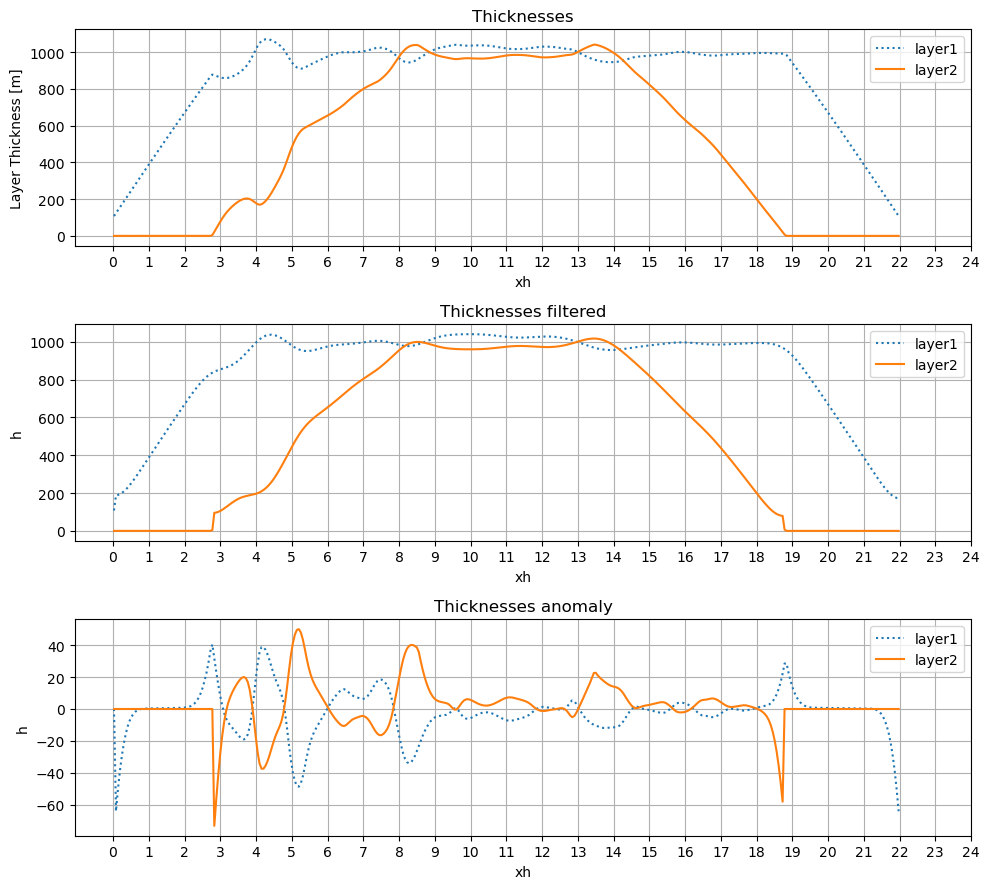

In [29]:
plt.figure(figsize=(10,9))

plt.subplot(311)
ds.h.isel( zl=0).sel(yh=40, method='nearest').plot(linestyle=':',label='layer1')
ds.h.isel( zl=1).sel(yh=40, method='nearest').plot(label='layer2')
plt.legend()
plt.xticks(np.arange(0,25, 1));
plt.title('Thicknesses')
plt.grid()

plt.subplot(312)
ds_filt.h.isel(zl=0).sel(yh=40, method='nearest').plot(linestyle=':',label='layer1')
ds_filt.h.isel(zl=1).sel(yh=40, method='nearest').plot(label='layer2')
plt.legend()
plt.xticks(np.arange(0,25, 1));
plt.title('Thicknesses filtered')
plt.grid()

plt.subplot(313)
ds_anom.h.isel(zl=0).sel(yh=40, method='nearest').plot(linestyle=':',label='layer1')
ds_anom.h.isel(zl=1).sel(yh=40, method='nearest').plot(label='layer2')
plt.legend()
plt.xticks(np.arange(0,25, 1));
plt.title('Thicknesses anomaly')
plt.grid()

plt.tight_layout()

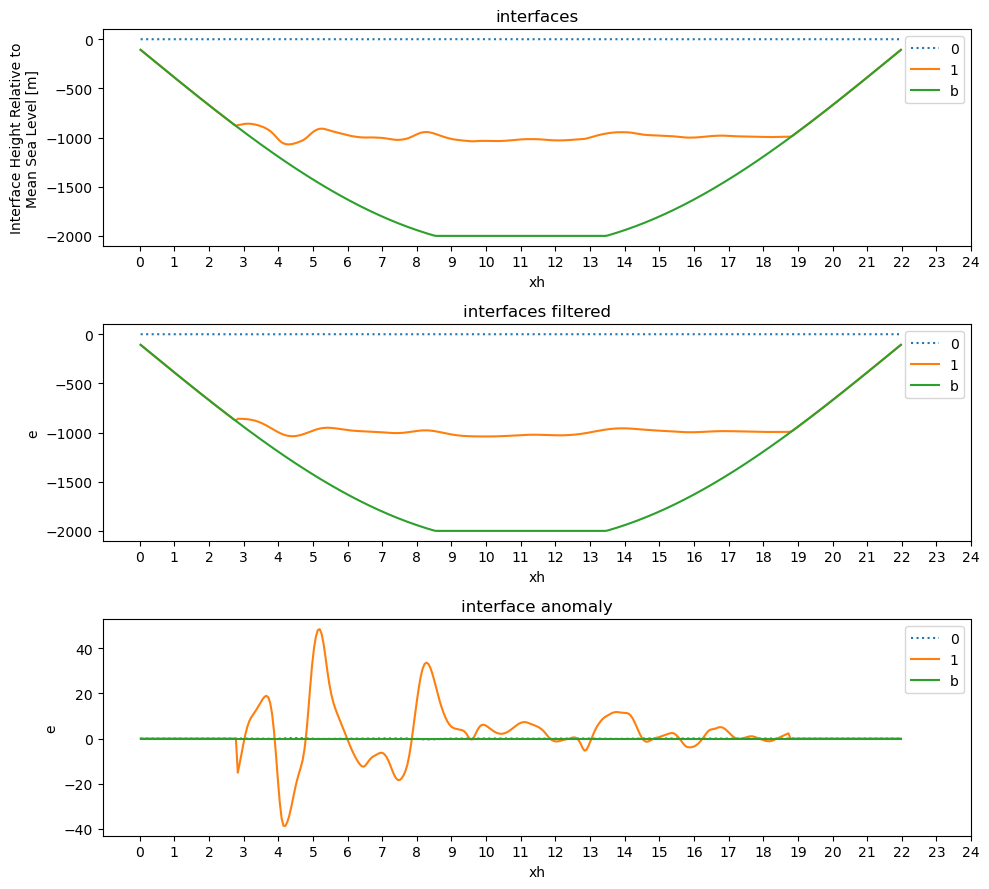

In [30]:
plt.figure(figsize=(10,9))

plt.subplot(311)
ds.e.isel( zi=0).sel(yh=40, method='nearest').plot(linestyle=':',label='0')
ds.e.isel( zi=1).sel(yh=40, method='nearest').plot(label='1')
ds.e.isel( zi=2).sel(yh=40, method='nearest').plot(label='b')
plt.legend()
plt.xticks(np.arange(0,25, 1));
plt.title('interfaces')

plt.subplot(312)
ds_filt.e.isel( zi=0).sel(yh=40, method='nearest').plot(linestyle=':',label='0')
ds_filt.e.isel( zi=1).sel(yh=40, method='nearest').plot(label='1')
ds_filt.e.isel( zi=2).sel(yh=40, method='nearest').plot(label='b')
plt.legend()
plt.xticks(np.arange(0,25, 1));
plt.title('interfaces filtered')

plt.subplot(313)
ds_anom.e.isel( zi=0).sel(yh=40, method='nearest').plot(linestyle=':',label='0')
ds_anom.e.isel( zi=1).sel(yh=40, method='nearest').plot(label='1')
ds_anom.e.isel( zi=2).sel(yh=40, method='nearest').plot(label='b')
plt.legend()
plt.xticks(np.arange(0,25, 1));
plt.title('interface anomaly')

plt.tight_layout()

note that there are 2 things going on above to do with topography. 
1. There is the boundary issue, where the filter passes through the boundary, which creates a spike.
2. Also the filtered bottom interface is always a bit below the unfiltered (concave shape), which add a sign definite bias. [Except in region with flat bottom].

Does any of this impact the fluxes? 

In [31]:
u_c = xgrid.interp(ds.u.fillna(0), 'X')
v_c = xgrid.interp(ds.v.fillna(0), 'Y')
ds_filt['u'] = filter_C_h.apply(u_c, dims=['yh','xh']).rename('u')
ds_filt['v'] = filter_C_h.apply(v_c, dims=['yh','xh']).rename('v')

In [32]:
## Thickness method <uh> - <u><h>
ds_filt['vh'] = ds.h*v_c
ds_filt['vh_bar'] = filter_C_h.apply(ds_filt['vh'], dims=['yh','xh']).rename('vh_bar')
ds_filt['vbar_hbar'] = (ds_filt.h*ds_filt.v)
ds_filt['vh_sg'] = ds_filt['vh_bar'] - ds_filt['vbar_hbar']

ds_filt['uh'] = ds.h*u_c
ds_filt['uh_bar'] = filter_C_h.apply(ds_filt['uh'], dims=['yh','xh']).rename('uh_bar')
ds_filt['ubar_hbar'] = (ds_filt.h*ds_filt.u)
ds_filt['uh_sg'] = ds_filt['uh_bar'] - ds_filt['ubar_hbar']

In [33]:
xgrid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (not periodic, boundary=None):
  * center   yh --> outer
  * outer    yq --> center
Z Axis (not periodic, boundary=None):
  * center   zl --> outer
  * outer    zi --> center

In [34]:
## Interface method 
ds_filt['v2e1'] = ds.e.isel(zi=1)*v_c.isel(zl=1)
ds_filt['v2e1_bar'] = filter_C_e.apply(ds_filt['v2e1'], dims=['yh','xh']).rename('v2e1_bar')
ds_filt['v2bar_e1bar'] = (ds_filt.e.isel(zi=1)*ds_filt.v.isel(zl=1))
ds_filt['v2e1_sg'] = ds_filt['v2e1_bar'] - ds_filt['v2bar_e1bar']

ds_filt['u2e1'] = ds.e.isel(zi=1)*u_c.isel(zl=1)
ds_filt['u2e1_bar'] = filter_C_e.apply(ds_filt['u2e1'], dims=['yh','xh']).rename('u2e1_bar')
ds_filt['u2bar_e1bar'] = (ds_filt.e.isel(zi=1)*ds_filt.u.isel(zl=1))
ds_filt['u2e1_sg'] = ds_filt['u2e1_bar'] - ds_filt['u2bar_e1bar']

### Algorithm for computing 



In [35]:
interafaces = 3
ds['e_up'] = xr.DataArray(ds.e.isel(zi=slice(0, -1)).data, 
                         dims=['zl','yh','xh'])
ds['e_low'] = xr.DataArray(ds.e.isel(zi=slice(1, None)).data, 
                         dims=['zl','yh','xh'])


In [36]:
ds.e_up

<xarray.DataArray 'e_up' (zl: 2, yh: 440, xh: 400)> Size: 1MB
dask.array<getitem, shape=(2, 440, 400), dtype=float32, chunksize=(2, 440, 400), chunktype=numpy.ndarray>
Coordinates:
    Time     object 8B 0099-07-26 00:00:00
  * xh       (xh) float64 3kB 0.0275 0.0825 0.1375 0.1925 ... 21.86 21.92 21.97
  * yh       (yh) float64 4kB 30.02 30.07 30.11 30.16 ... 49.89 49.93 49.98
  * zl       (zl) float64 16B 1.035e+03 1.036e+03

In [37]:
ds

<xarray.Dataset> Size: 12MB
Dimensions:  (zl: 2, yq: 441, xq: 401, zi: 3, yh: 440, xh: 400)
Coordinates:
    Time     object 8B 0099-07-26 00:00:00
  * xh       (xh) float64 3kB 0.0275 0.0825 0.1375 0.1925 ... 21.86 21.92 21.97
  * xq       (xq) float64 3kB 0.0 0.055 0.11 0.165 ... 21.84 21.89 21.95 22.0
  * yh       (yh) float64 4kB 30.02 30.07 30.11 30.16 ... 49.89 49.93 49.98
  * yq       (yq) float64 4kB 30.0 30.05 30.09 30.14 ... 49.86 49.91 49.95 50.0
  * zi       (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
  * zl       (zl) float64 16B 1.035e+03 1.036e+03
Data variables:
    RV       (zl, yq, xq) float32 1MB dask.array<chunksize=(2, 441, 401), meta=np.ndarray>
    e        (zi, yh, xh) float32 2MB dask.array<chunksize=(3, 440, 400), meta=np.ndarray>
    h        (zl, yh, xh) float64 3MB dask.array<chunksize=(2, 440, 400), meta=np.ndarray>
    u        (zl, yh, xq) float32 1MB dask.array<chunksize=(2, 440, 401), meta=np.ndarray>
    v        (zl, yq, xh) float32 1MB dask.array<chunksize=(2, 441, 400), meta=np.ndarray>
    e_up     (zl, yh, xh) float32 1MB dask.array<chunksize=(2, 440, 400), meta=np.ndarray>
    e_low    (zl, yh, xh) float32 1MB dask.array<chunksize=(2, 440, 400), meta=np.ndarray>
Attributes:
    filename:   prog__000010.nc
    grid_tile:  N/A
    grid_type:  regular
    title:      MOM Experiment

In [38]:
ds['wet_mask_up'] = xr.DataArray(wet_mask_e.isel(zi=slice(0, -1)).data, 
                         dims=['zl','yh','xh'])
ds['wet_mask_low'] = xr.DataArray(wet_mask_e.isel(zi=slice(1, None)).data, 
                         dims=['zl','yh','xh'])


In [39]:
filter_scale

20

In [40]:
dx_min

1

In [41]:
filter_C_up = gcmf.Filter(filter_scale= filter_scale,  
                     dx_min = dx_min, 
                     filter_shape=gcmf.FilterShape.GAUSSIAN,
                     grid_type=gcmf.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
                     grid_vars = {'area':area_t,'wet_mask': ds['wet_mask_up']})

filter_C_low = gcmf.Filter(filter_scale= filter_scale,  
                     dx_min = dx_min, 
                     filter_shape=gcmf.FilterShape.GAUSSIAN,
                     grid_type=gcmf.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
                     grid_vars = {'area':area_t,'wet_mask': ds['wet_mask_low']})


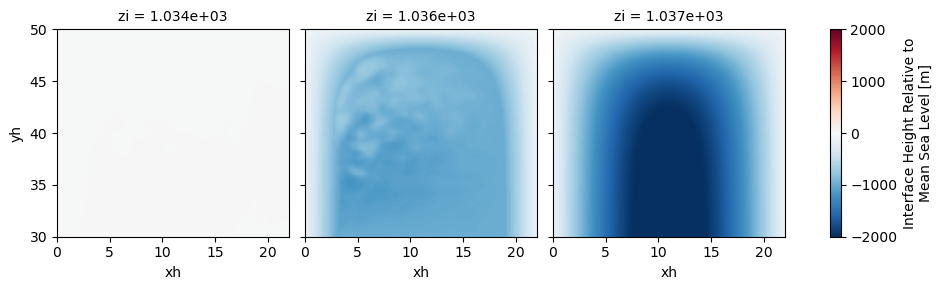

In [42]:
ds.e.plot(col='zi')

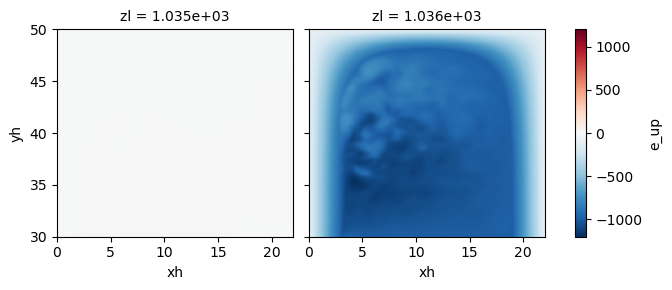

In [43]:
ds.e_up.plot(col='zl')

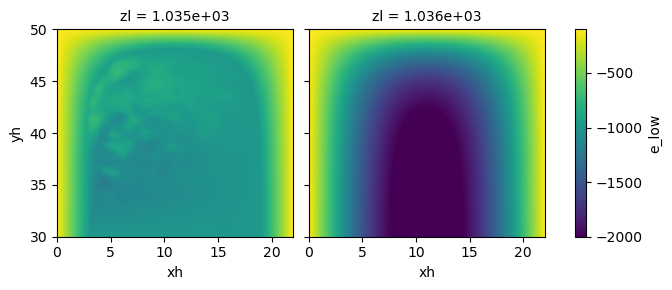

In [44]:
ds.e_low.plot(col='zl')

In [45]:
ue_up_bar = filter_C_up.apply(u_c * ds.e_up, dims=['yh','xh'])#.rename('v2e1_bar')
ue_low_bar = filter_C_low.apply(u_c * ds.e_low, dims=['yh','xh'])#.rename('v2e1_bar')

ubar_ebar_up = filter_C_up.apply(u_c, dims=['yh','xh']) * filter_C_up.apply(ds.e_up, dims=['yh','xh'])
ubar_ebar_low = filter_C_low.apply(u_c, dims=['yh','xh']) * filter_C_low.apply(ds.e_low, dims=['yh','xh'])

In [46]:
uh_bar = ue_up_bar - ue_low_bar
ubar_hbar = ubar_ebar_up - ubar_ebar_low


In [47]:
uphp = uh_bar - ubar_hbar

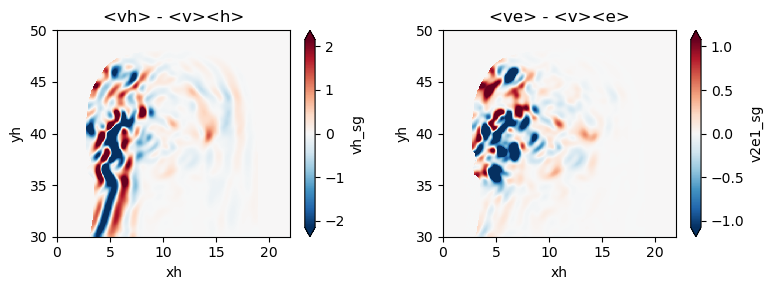

In [36]:
plt.figure(figsize=(8,3))

plt.subplot(121)
ds_filt['vh_sg'].isel(zl=-1, Time=-1).plot(robust=True)
plt.title('<vh> - <v><h>')

plt.subplot(122)
ds_filt['v2e1_sg'].isel( Time=-1).plot(robust=True)
plt.title('<ve> - <v><e>')

plt.tight_layout()

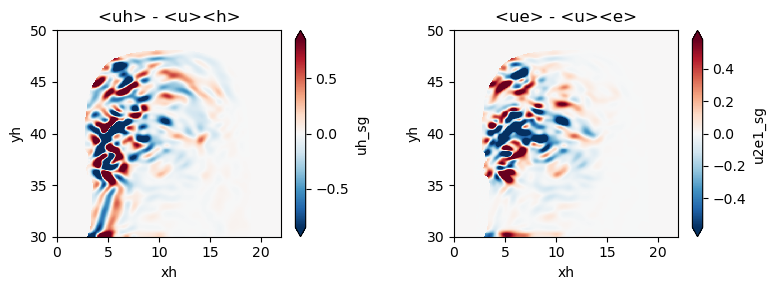

In [37]:
plt.figure(figsize=(8,3))

plt.subplot(121)
ds_filt['uh_sg'].isel(zl=-1, Time=-1).plot(robust=True)
plt.title('<uh> - <u><h>')

plt.subplot(122)
ds_filt['u2e1_sg'].isel( Time=-1).plot(robust=True)
plt.title('<ue> - <u><e>')

plt.tight_layout()

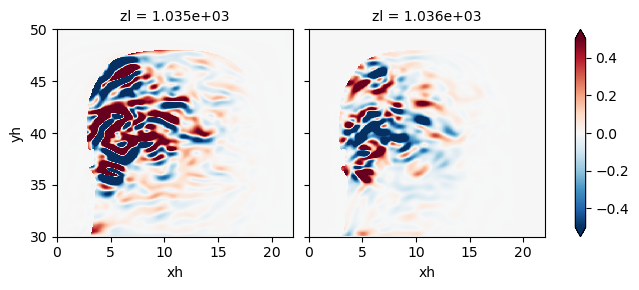

In [83]:
uphp.plot(col='zl', vmin=-.5)

In [ ]:
plt.figure(figsize=(8,3))

plt.subplot(121)
ds_filt['vh_sg'].isel(zl=-1, Time=slice(-100,-1)).mean('Time').plot(robust=True)
plt.title('<vh> - <v><h>')

plt.subplot(122)
ds_filt['v2e1_sg'].isel(Time=slice(-100,-1)).mean('Time').plot(robust=True)
plt.title('<ve> - <v><e>')

plt.tight_layout()

## When done

In [64]:
cluster.shutdown()